## Ý tưởng

Quá trình training và update trọng số... Vẫn theo nguyên tắc như mạng GAN cơ bản.

Tuy nhiên với hai model Generator và Discriminator trước đây dùng Neural Network thì bây giờ dùng CNN

## Ví dụ cho mô hình Generator

- Mô hình CNN cho Generator sẽ hơi khác CNN bình thường vì mục đích của Generator là tạo ảnh giống ảnh ban đầu => Width, Height tăng và Depth giảm

=> Sử dụng Transpose Convolution Layer

![](../../images/dcgan1.png)

## Ví dụ cho mô hình Discriminator

Mô hình cho Discriminator sẽ là mạng CNN thường vì dùng cho bài toán classification

![](../../images/dcgan2.png)

## Implementation in Pytorch

In [62]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt


In [63]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Device

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyper parameters

In [65]:
batch_size = 32

## Dataset

In [66]:
datatransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [67]:
train_dataset = CIFAR10(root="../../data", download=True, transform=datatransforms)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

Files already downloaded and verified


## Utils

In [68]:
def show(imgs_grid):
    imgs_grid = imgs_grid.detach()
    imgs_grid = torchvision.transforms.functional.to_pil_image(imgs_grid)
    
    plt.imshow(np.asarray(imgs_grid))
    plt.show()

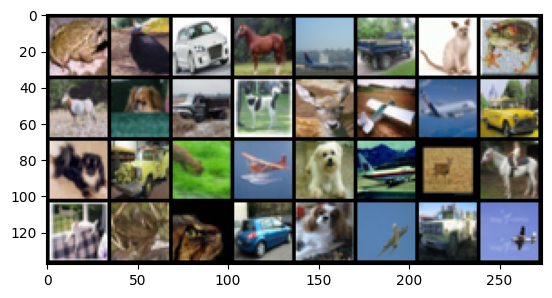

In [69]:
samples = iter(train_loader)

images, labels = next(samples)

img_grid = torchvision.utils.make_grid(images)

show(img_grid)

## Models

In [70]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(128, 2048)
        self.upsample = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.fc1(x)
        out = out.reshape(x.size(0), 512, 2, 2)
        out = self.upsample(out)
        
        return out
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifiers = nn.Linear(2048, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.classifiers(out)
        out = self.sigmoid(out)
        
        return out
    



## Training

In [71]:
G = Generator().to(device)
D = Discriminator().to(device)

In [72]:
fixed_noise = torch.randn((batch_size, 128)).to(device)

In [73]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=2e-3)
d_optimizer = torch.optim.Adam(D.parameters(), lr=2e-3)

# g_loss = nn.BCELoss()
# d_loss = nn.BCELoss()
criterion = nn.BCELoss()

writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

In [74]:
img, label = train_dataset[0]


img

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

In [75]:
epochs = 50
z_dim = 128

In [76]:
for epoch in range(epochs):
    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        
        batch_size = real.shape[0]
        
        ### Train Discriminator: max log(D(real)) + log(1 - D(g(z))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = G(noise).to(device)
        disc_real = D(real).view(-1).to(device)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = D(fake).view(-1).to(device)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        
        lossD = (lossD_fake + lossD_real) / 2
        D.zero_grad()
        lossD.backward(retain_graph=True)
        d_optimizer.step()
        
        ### Train Generator min log(1-D(G(z))) <-> max log(D(G(z)))
        output = D(fake).view(-1).to(device)
        lossG = criterion(output, torch.ones_like(output))
        G.zero_grad()
        lossG.backward()
        g_optimizer.step()
        
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/ {epochs}] \ "
                f"Loss D: {lossD:.4f}, Loss G: {lossG:.4f}"
            )
            with torch.no_grad():
                fake = G(fixed_noise)
                data = real
                
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)
                
                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                
                writer_fake.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                
                step +=1
                
                
        
        
        
        
        
        

Epoch [0/ 50] \ Loss D: 0.6886, Loss G: 3.2057
Epoch [1/ 50] \ Loss D: 0.0000, Loss G: 12.1114


KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir=runs